***
In this notebook, we will begin with creating a pcraster map of clonemap and DEM, respectively, for a SPHY model input.
***

# 00. Load Packages

In [1]:
import os
import pcraster as pcr
import pcr_tool

import cartopy

# 01. Basic Setup for a Bhutan watershed (Punatsangchhu, Wangchhu, Amochhu, and Jaldakah)

In [2]:
epsg_model = 5266 # Bhutan National Grid: a transverse Mercator projection
epsg_lonlat = 4326 # the common lat-lon coordinate reference system

path_data = os.path.join('..', 'data')
path_output = os.path.join('..', 'input') # the "input" folder will be directly used as an input path for the SPHY model run
os.makedirs(path_output, exist_ok = True)

# plotting options
flag_plot_aguila = True
flag_plot_cartopy = True

# Bhutan Administrative Boundaries (Level 1) to be added in a plot
path_shape = os.path.join(path_data, 'SHAPE', 'btn_admbnda_adm1_bnlc_20201026.shp')
shape_geometry = cartopy.io.shapereader.Reader(path_shape).geometries()
shape_feature = cartopy.feature.ShapelyFeature(shape_geometry, crs = cartopy.crs.PlateCarree(), facecolor = 'none', linewidth = 0.25)

# 02. Create Clonemap

"Clonemap" is a pcraster map that defines a computationoal domain and its resolution using a bool (True/False) instance.<br>

First, we need to declare the class that we will be using throughout this notebook, with an EPSG to define a clonemap.

In [3]:
print(f'- Input EPSG:\n{epsg_model}')
map_clone = pcr_tool.clonemap(epsg = epsg_model)

- Input EPSG:
5266


Then, let's create a clonemap based on the clonemap properties (number of rows and columns, cellsize, and west/north ends).

- Outputs:
write_pcraster - clone.map: written to ../input/clone.map.


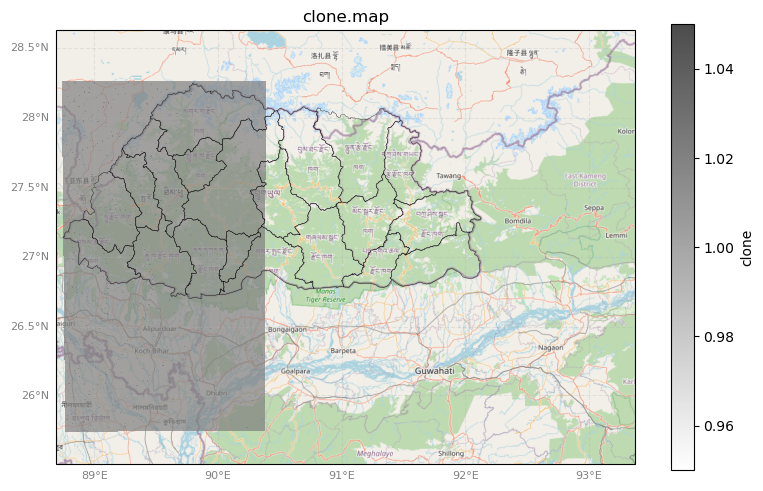

In [4]:
resolution = 1000 # 1km

print('- Outputs:')
#map_clone.create_clonemap(nrow = 348, ncol = 472, cellsize = resolution, west = 118000, north = 3168000) # Bhutan River Basin (west: 118000, east: 590000, south: 2820000, north: 3168000)
map_clone.create_clonemap(
    nrow = 280, # number of rows (x)
    ncol = 162, # number of columns (y)
    cellsize = resolution, # cell size (resolution)
    west = 126000, # coordinate for west boundary
    north = 3128000, # coordinate for north boundary
    ) # HYBAS ID: 4060900670 (west: 126000, east: 288000, south: 2848000, north: 3128000)

# export into a pcraster file
map_clone.write_pcraster(path = os.path.join(path_output, 'clone.map')) # export into a pcratser file

# plots
if flag_plot_aguila: pcr.aguila(map_clone.clonemap)
if flag_plot_cartopy:
    map_clone.plot_cartopy(
        field = map_clone.clonemap, # pcraster.Field to plot
        shapes = [shape_feature], # a list of cartopy.feature.ShapelyFeature to plot together
        figsize = (8, 5), # matplotlib figure size
        basemap = cartopy.io.img_tiles.OSM(), # cartopy basemap (here, OpenStreetMap)
        basemap_level = 8, # cartopy basemap zoom level
        extent = [88.6875, 93.375, 25.5, 28.625], # cartopy map extent
        vmin = None, # matplotlib contour min
        vmax = None, # matplotlib contour max
        cmap = 'binary', # matplotlib contour colormap
        alpha = 0.7, # matplotlib contour transparency
        title = 'clone.map', # matplotlib figure title
        clabel = 'clone', # matplotlib contour label
        savefig = None, # path to save the figure
        )

# 03. Set DEM

Next, we're going to subset a DEM raster (e.g., HydroSHED Conditioned DEM) for the clonemap.

- Input GEOTIFF Path for DEM:
../data/DEM/as_con_3s_subset.tif
- Outputs:
write_pcraster: written to ../input/dem.map.


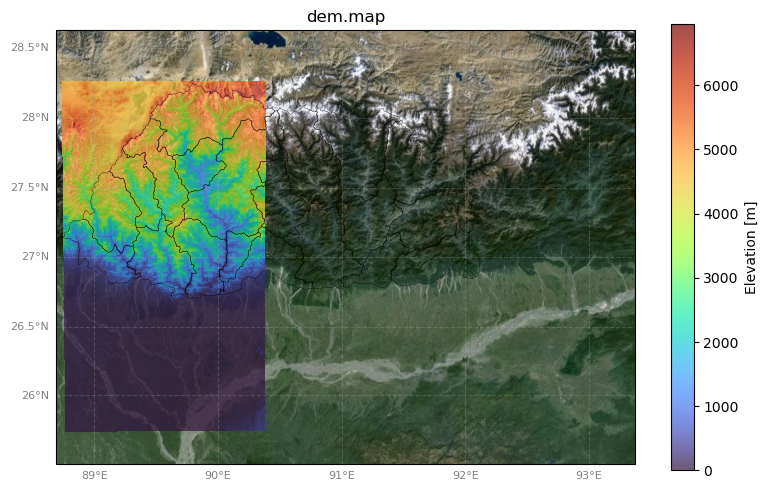

In [5]:
path_dem = os.path.join(path_data, 'DEM', 'as_con_3s_subset.tif')

print(f'- Input GEOTIFF Path for DEM:\n{path_dem}')
# pass "epsg = epsg_lonlat" as the DEM file has a different CRS (lat/lon)
map_dem = map_clone.read_raster(
    path = path_dem, # geotiff path to read
    epsg = epsg_lonlat, # input EPSG
    datatype = pcr.Scalar, # pcraster data type
    band = 1, # band number to read
    ) # automatically subset the input based on the clonemap extent
map_clone.set_dem(map_dem) # set as a default DEM

print('- Outputs:')
print(map_dem)

# export into a pcraster file
map_clone.write_pcraster(
    path = os.path.join(path_output, 'dem.map'), # path to write in the pcraster format
    field = map_dem, # pcraster.Field to write
    )

# plots
if flag_plot_aguila: pcr.aguila(map_dem)
if flag_plot_cartopy:
    map_clone.plot_cartopy(
        field = map_dem, # pcraster.Field to plot
        shapes = [shape_feature], # a list of cartopy.feature.ShapelyFeature to plot together
        figsize = (8, 5), # matplotlib figure size
        basemap = cartopy.io.img_tiles.GoogleTiles(style = 'satellite'), # cartopy basemap (here, Google Satellite Images)
        basemap_level = 8, # cartopy basemap zoom level
        extent = [88.6875, 93.375, 25.5, 28.625], # cartopy map extent
        vmin = None, # matplotlib contour min
        vmax = None, # matplotlib contour max
        cmap = 'turbo', # matplotlib contour colormap
        alpha = 0.7, # matplotlib contour transparency
        title = 'dem.map', # matplotlib figure title
        clabel = 'Elevation [m]', # matplotlib contour label
        savefig = None, # path to save the figure
        )

**NOTE**: we should be aware of a DEM raster that may require additional conditioning based upon catchment delineations, which will be shown in the next notebook.